In [1]:
### Creating an Airport class and a Graph class that holds Airports as vertices ###

class Airport: 
# Attributes:
# name: The airport's 3-letter IATA code
# routes: A dictinoary holding directly accessible airports and cheapest price, serving as the weight.
    def __init__(self, name, routes=None): 
        self.name = name
        self.routes = routes
        if not routes: 
            self.routes = {}
        
    def add_route(self,dest,price=0): 
        if dest.name in self.routes: 
            if price < self.routes[dest.name]:  #The function keeps only the cheapest route.
                self.routes[dest.name] = price  #Consequently, there are 36k routes vs 66k in the file
        else:
            self.routes[dest.name] = price
    
    def __lt__(self,other): #helps to handle cases of equal distances in the algorithm
        return self    

class Graph: 
#The graph holds a dictionary of airports.

    def __init__(self, airports={}): 
        self.airports = airports
        
    def add_airport(self,airport): 
        self.airports[airport.name] = airport
        
    def add_route(self,a1,a2, price): 
        self.airports[a1].add_route(self.airports[a2], price)

In [2]:
### Import airport and routes data from CSV Files and populate the relevant data structures ###

G = Graph({}) #The graph that will hold all airports
airports = {} #A dictionary that hold airport names and their textual description

filename = 'airportsnames.csv' #The file that contains all airports and their descriptions
with open(filename, 'r',encoding='utf-8') as f:
    for line in f:
        test = line.encode("ascii","ignore") #Ignore special characters in data. I found no better solution
        text = str(test).split(',',1) #Divide data to name - description
        name=text[0][2:]
        desc=text[1][1:-4]
        G.add_airport(Airport(name)) #Add the airport to the graph
        airports[name]=desc #Add the airport to the desceiption dictionary

filename = 'routes.csv' #The file that contains routes in the format departure-arrival-price
with open(filename, 'rb') as f:
    count = 0
    for line in f:
        route = str(line).split(',',2) #prepare data in format dep-arr-price
        if count==0: #fix the syntax of the first row of the file
            dep=route[0][-3:]
            count+=1
        else:
            dep=route[0][2:] 
        arr = route[1] 
        price=route[2][:-5] 
        G.add_route(dep,arr,int(price)) #add to graph after cleaning

routes = 0
for n,airport in G.airports.items(): #Count unique routes in the graph (keeps only cheapest)
    routes+=len(airport.routes)
airs = len(airports)

In [3]:
### Adapted Dijkstra's Algorithm to find the cheapest route up to a given stops limit ###

import heapq 

def initialize_dist(G,s): 
#Input: Airports graph and a source node
#The function initialize two dictitonaries holding distances and paths from the source for each airport
#Output: Initialized distances and paths dictionary 

    wdist,path = {}, {}
    for n,v in G.airports.items(): 
        wdist[n]= float('inf') #Weighted distance from source representing the total price of the route
        path[n] = '' #A concatenated string of all airport names visited in a path (e.g. 'SFOTLV' for SFO-TLV)
    wdist[s.name] = 0
    return wdist,path

def dijkstra(G,s,t,n):
#Input: the airport graph, a (s)ource and (t)arget airports and (n)umber of allowed stops
#The function scans the graph for the cheapest route from s->t in n or less stops.
#Output: a tuple with the price, the full path and the largest size the priority queue reached

    wdist,path = initialize_dist(G,s)
    Q = [(0,s)] #pririty queue that holds vertices, to choose the cheapest path first each iteration
    maxq, push, pop = 0, 0, 0 #measures the largest queue size, number of pushes and number of pops.
    
    if (t.name in s.routes): #checks for direct route, an upper price boundary saving relaxations
        wdist[t.name]=s.routes[t.name]
        path[t.name]+=s.name
        Q.append((wdist[t.name],t))

    while Q:
        if len(Q) > maxq:
            maxq=len(Q)
            
        wd, u = heapq.heappop(Q) #current distance and airport examined
        pop+=1
        
        if u.name==t.name: #termination condition
            path[u.name]+=str(u.name)
            return (wd,path[u.name],maxq,push,pop)
                    
        if len(path[u.name])/3==n: #At this point, a relevant path will exist only if u->t exists. n stops allow a path with n+2 airports and this check is before adding the current node and the target tot he path.
            if t.name in u.routes: #check only if a direct route u->t exists
                if (wdist[t.name] > wd + u.routes[t.name]) or (wdist[t.name] == wd + u.routes[t.name] and path[t.name]>path[u.name]+str(u.name)): #Either the new path is cheaper than current one or equal but with less stops.
                    wdist[t.name] = wd + u.routes[t.name] #update the distance of target node to u.d+price(u->t)
                    path[t.name] = path[u.name]+ str(u.name) #add u to the path to t
                    heapq.heappush(Q,(wdist[t.name],G.airports[t.name])) #add t with the found distance to the queue
                    push+=1
                
        elif len(path[u.name])/3<n: #At this point a path to an airport other than t could still reach t under n stops so all routes are checked.
            for name,price in u.routes.items(): 
                old_wdist, new_wdist, old_path, new_path = wdist[name], wd+price, path[name], path[u.name]+str(u.name)
                if ((old_wdist > new_wdist) or (old_wdist == new_wdist and old_path > new_path)) and ((wdist[t.name] > new_wdist) or (name==t.name)): #Two conditions are needed: the new path to connected airport is cheaper than before (or equal with less stops), and the new path is cheaper than current cheapest path to t (or the connected airport is t, and then the first condition determines relaxation)
                    wdist[name] = new_wdist
                    path[name] = new_path
                    heapq.heappush(Q,(wdist[name],G.airports[name]))
                    push+=1
    
    return (wdist[t.name],path[t.name], maxq, push, pop) #If all nodes were checked and it got here, no path was found

In [4]:
### Auxiliary functions to get user input and print output ###

def get_input():
#The function prompts the user to obtain airports codes of departure and arrival and maximum stops
#Output: 3-letter names of departure and arrival airports and maximum stops as inserted

    city = input(">>> Insert 'help' to show codes of available airports for a location, or enter to continue: ")
    if city=='exit':
        return (0,0,0)
    elif city=='help': #Present user with airport codes in a desired locations
        approved=False
        while not approved: 
            city = input('>>> Insert name of desired city or country (partial names supported): ')
            for name,desc in airports.items():
                if city.lower() in desc.lower():
                    print("Code:",name,"Description:",desc)
            another = input(">>> Search another location? 'y' / 'n': ")
            if another == 'exit':
                return (0,0,0)
            if another!='y':
                approved=True
                
    approved = False
    dep = input('>>> Insert airport of departure using 3-letter IATA code: ').upper()
    if dep == 'EXIT':
        return (0,0,0)
    while not approved: #verify the departure airport exists
        if dep not in G.airports:
            print (">>> Airport does not exist.",len(airports),"other airports exist, it's not that hard. ")
            dep = input(">>> Insert choice for a new departure airport: ").upper()
            if dep=='EXIT':
                return (0,0,0)
        else:
            approved = True
    
    approved = False
    arr = input('>>> Insert airport of arrival using 3-letter IATA code: ').upper()
    if arr == 'EXIT':
        return (0,0,0)
    while not approved: #verify the arrival airport exists and different than departure
        if arr not in G.airports:
            print ("Airport does not exist.",len(airports),"other airports exist, it's not that hard. ")
            arr = input(">>> Insert choice for a new arrival airport: ").upper()
            if arr == 'EXIT':
                return (0,0,0)
        elif arr==dep:
            print ("You are already here, no flight needed (can't pick the same airport twice)")
            arr = input(">>> Insert choice for a new arrival airport: ").upper()
            if arr == 'EXIT':
                return (0,0,0)
        else:
            approved = True
    
    approved = False
    stops = input('>>> Insert maximum number of stops, 0 for direct flights only (less fun): ')
    if stops == 'exit':
        return (0,0,0)
    while not approved: #verify it's a number
        if not stops.isdigit():
            stops = input(">>> Insert a number, please: ").upper()
            if stops == 'exit':
                return (0,0,0)
        else:
            approved = True
    
    print("\n***\nYour query:", dep,"to",arr,"with maximum",stops,"stops\n***\n")
    return (dep,arr,int(stops))

def format_results(r):
#Input: results array from Dijkstra's results in the format (price, path, maxq)
#The function formats and prints the information obtained from the algorithm

    price, path = r[0],r[1]
    apts = [path[i:i+3] for i in range(0, len(path), 3)] #transforming paths to airport list

    if price == float('inf'):
        print("No path found, try adding stops or change airports")
        return
    
    if apts[-1] in G.airports[apts[0]].routes: #if a direct flight existed
        print ("A direct flight exists. Price:", G.airports[apts[0]].routes[apts[-1]])
                               
    if len(apts)==2:
        print ("It is also the cheapest flight found. How mundane.")
        print ("Perhaps increasing the number of stops will yield cheaper routes.")
    else:
        print ("Best result: route from",apts[0],"to",apts[-1],"with total price",price,'\n')
        for i in range(len(apts)-1):
            print ("Flight #"+str(i+1))
            print("Departure:",apts[i],airports[apts[i]])
            print("Arrival:",apts[i+1],airports[apts[i+1]])
            print("Price:",G.airports[apts[i]].routes[apts[i+1]],'\n')

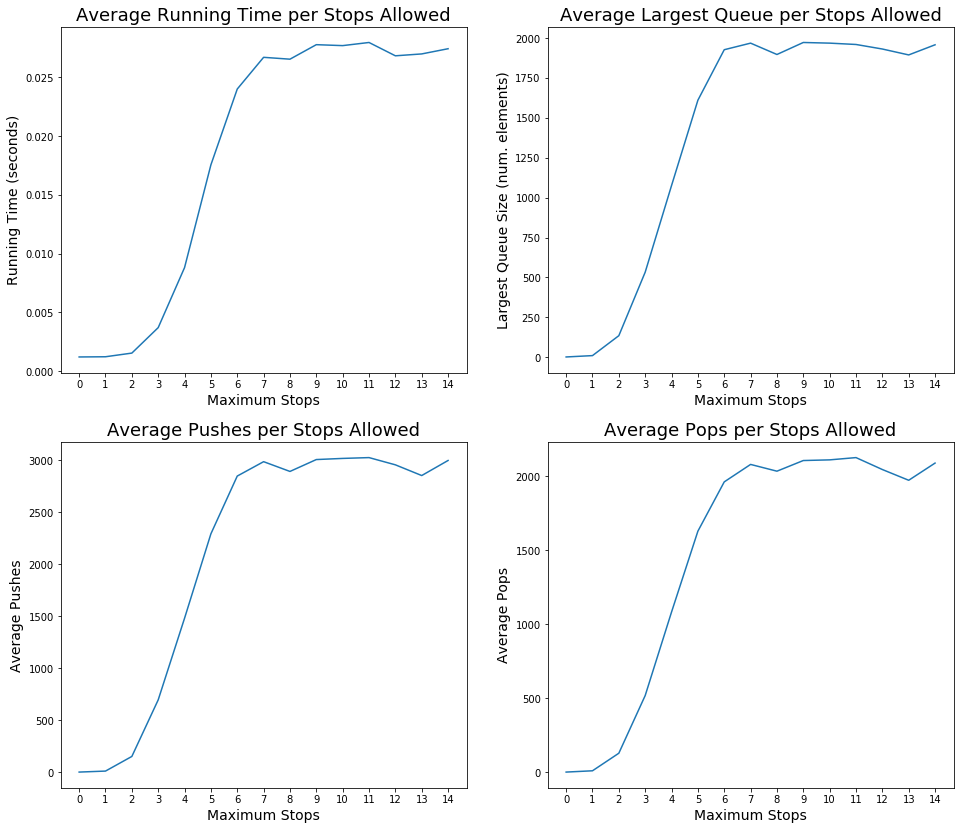

In [5]:
### Performance Analysis ###

import random
import matplotlib.pyplot as plt
import time

sims = 300 #Number of simulations per stops size
cap = 15 #Number of stop sizes to check (0-cap)
q_lengths, times, pushes, pops = [0]*cap, [0]*cap, [0]*cap, [0]*cap #capture results of running time and Queue length

for i in range(cap): 
    for j in range(sims): 
        src = random.choice(list(G.airports.keys()))
        dst = random.choice(list(G.airports.keys()))
        stops = i
        start = time.time()
        results = dijkstra(G,G.airports[src],G.airports[dst],stops)
        end = (time.time()-start)
        times[i]+= end/sims
        q_lengths[i]+=(results[2]/sims) #the part that captures maximum q length
        pushes[i]+= (results[3]/sims) #same for pushes
        pops[i]+= (results[4]/sims) #same for pops

plt.figure(figsize=(16,14)) #code to produce to figures
p1 = plt.subplot(222)
plt.plot(list(range(cap)),q_lengths)
plt.xticks(list(range(cap)))
plt.title("Average Largest Queue per Stops Allowed", fontsize=18)
plt.ylabel("Largest Queue Size (num. elements)", fontsize=14)
plt.xlabel("Maximum Stops", fontsize=14)

p2 = plt.subplot(221)
plt.plot(list(range(cap)),times)
plt.xticks(list(range(cap)))
plt.title("Average Running Time per Stops Allowed", fontsize=18)
plt.ylabel("Running Time (seconds)", fontsize=14)
plt.xlabel("Maximum Stops", fontsize=14)

p3 = plt.subplot(223)
plt.plot(list(range(cap)),pushes)
plt.xticks(list(range(cap)))
plt.title("Average Pushes per Stops Allowed", fontsize=18)
plt.ylabel("Average Pushes", fontsize=14)
plt.xlabel("Maximum Stops", fontsize=14)

p4 = plt.subplot(224)
plt.plot(list(range(cap)),pops)
plt.xticks(list(range(cap)))
plt.title("Average Pops per Stops Allowed", fontsize=18)
plt.ylabel("Average Pops", fontsize=14)
plt.xlabel("Maximum Stops", fontsize=14)

plt.show()

In [8]:
### Main - Initiate User Interface ###

print("*** Under The Radar: Alternative Fare Comparison ***\n")
print("Welcome to yet another fare comparison service. \nWe find surprisingly cheap routes with connections that defy any geo-economical sense.")
print("We find routes between a pair of airports given in IATA 3-digit format (SFO, TLV, ETC.).")
print("Currently supporting",airs,"airports and",routes,"unique routes.")
print("Typing 'exit' at any point will stop the application.")

src,dst,stops = get_input()
done = False
if src==0:
    print ("Bye")
    done = True
while not done:
    results=dijkstra(G,G.airports[src],G.airports[dst],stops)
    format_results(results)
    again = input("Run another query? 'y' / 'n' ")
    if again == 'y':
        src,dst,stops = get_input()
        if src==0:
            print ("Bye")
            done = True
    else:
        print ("Bye")
        done = True

*** Under The Radar: Alternative Fare Comparison ***

Welcome to yet another fare comparison service. 
We find surprisingly cheap routes with connections that defy any geo-economical sense.
We find routes between a pair of airports given in IATA 3-digit format (SFO, TLV, ETC.).
Currently supporting 3179 airports and 36434 unique routes.
Typing 'exit' at any point will stop the application.
>>> Insert 'help' to show codes of available airports for a location, or enter to continue: help
>>> Insert name of desired city or country (partial names supported): vancouver
Code: YVR Description: Vancouver International Airport, Vancouver, Canada
Code: CXH Description: Vancouver Harbour Water Aerodrome, Vancouver, Canada
>>> Search another location? 'y' / 'n': y
>>> Insert name of desired city or country (partial names supported): cairo
Code: CAI Description: Cairo International Airport, Cairo, Egypt
>>> Search another location? 'y' / 'n': n
>>> Insert airport of departure using 3-letter IATA cod

In [7]:
### Testing Zone ###

#test = Graph({})
#test.add_airport(Airport('sss',{'aaa':120,'bbb':50,'ccc':30,'ddd':15}))
#test.add_airport(Airport('aaa',{}))
#test.add_airport(Airport('bbb',{'ttt':40}))
#test.add_airport(Airport('ccc',{'ggg':5,'ttt':110}))
#test.add_airport(Airport('ddd',{'eee':10}))
#test.add_airport(Airport('eee',{'ttt':120}))
#test.add_airport(Airport('ggg',{'lll':10}))
#test.add_airport(Airport('lll',{'ttt':45}))
#test.add_airport(Airport('ttt',{}))
#results=dijkstra(test,test.airports['sss'],test.airports['ttt'],stops)

#dijkstra(G,G.airports['SXF'],G.airports['GPI'],stops) #five stops yields a new result!
#dijkstra(G,G.airports['NOJ'],G.airports['GPI'],stops) #six stops!
#G.airports['CXH'].routes #The CXH-YWH pocket - an example of an unreachable vertex